In [2]:
import numpy as np
from sklearn import naive_bayes
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import norm
from sklearn.metrics import confusion_matrix, fbeta_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
import pandas as pd
import pickle
from matplotlib import pyplot as plt

plt.rcParams["figure.dpi"] = 300

In [11]:
# Import dataset.
data = pd.read_csv("USE_MY_DATA.csv",low_memory=False, index_col=0)

In [12]:
data = pd.get_dummies(data,drop_first=True)

In [13]:
data.job_info_experience_num_months = data['job_info_experience_num_months'].fillna(np.mean(data['job_info_experience_num_months']))
data.employer_num_employees = data['employer_num_employees'].fillna(np.mean(data['employer_num_employees']))

In [14]:
scaler = MinMaxScaler()
data.pw_amount_new = scaler.fit_transform(data.pw_amount_new.values.reshape(len(data), 1))
data.job_info_experience_num_months = scaler.fit_transform(data.job_info_experience_num_months.values.reshape(len(data), 1))

In [8]:
def train_test_split_50(data1):
    '''
    This train test split, creates a test data that is 50% with target of 1 and 50% with target of 0.
    Currently, 25% of the data is in the testing set. 
    '''

    certified = data1.case_status_Denied==0
    denied = data1.case_status_Denied==1
    d = len(data1[denied])
    # Test split index (at 40%).
    tsi = int(np.ceil(d*.4))


    # Data that is declined and shuffle.
    d_data = data1[denied].sample(frac=1)

    # Data that is certified and shuffle.
    c_data = data1[certified].sample(frac=1)

    pd = list(np.random.permutation(len(d_data)))
    pc = list(np.random.permutation(len(c_data)))

    # Sample 40% of the denied data.
    test_d = d_data.iloc[pd[:tsi]]
    test_c = c_data.iloc[pc[:tsi]]

    test_set = (test_d.append(test_c)).sample(frac=1) # Shuffle the dataset. 

    X_test,Y_test = test_set.drop(["case_status_Denied"],axis = 1),test_set["case_status_Denied"]

    # Train data

    train_d = d_data.iloc[pd[tsi:]]
    train_c = c_data.iloc[pc[tsi:]]

    train_set = (train_d.append(train_c)).sample(frac=1) # Shuffle. 



    return train_set,X_test,Y_test

# K-nearest Neighbors

In [ ]:
# Train test split
train_set, X_test, y_test = train_test_split_50(data)

mask_c = train_set.case_status_Denied==0
mask_d = train_set.case_status_Denied==1
d = len(train_set[mask_d])

In [20]:
##### PICKLED FILE DO NOT RUN #####

# # Grid Search
# knn_scores = []
# knn_f2 = []
# # Set parameters
# for a in ['auto', 'brute']:
#     for w in ['uniform', 'distance']:
#         for n in [5, 10, 20]:
#             #parameters = {'n_neighbors': (5, 10, 20), 'weights': ('uniform', 'distance'), 'algorithm': ('auto', 'brute')}
#             # Run GridSearch
#             print(n, w, a)
#             pred = []
#              for i in range(5): 
#                 sample = train_set[mask_c].sample(d).append(train_set[mask_d])

#                 sample_X = sample.drop(['case_status_Denied'], axis=1)
#                 sample_Y = sample['case_status_Denied']
                
#                 knn = KNeighborsClassifier(n_neighbors=n, weights=w, algorithm=a)
#                 knn.fit(sample_X, sample_Y)
#                 pred.append(knn.predict(X_test))

#             knn_ensemble = np.sum(np.array(pred), axis=0) >=3

#             knn_scores.append(np.sum(knn_ensemble==np.array(y_test))/len(y_test))
#             print(fbeta_score(y_test,knn_ensemble,2))
#             knn_f2.append(fbeta_score(y_test,knn_ensemble,2))

5 uniform auto
0.725337899823
10 uniform auto
0.681302201579
20 uniform auto
0.697391734311
5 distance auto
0.730836698894
10 distance auto
0.731978535431
20 distance auto
0.727112999775
5 uniform brute
0.725183860875
10 uniform brute
0.679683278607
20 uniform brute
0.693986820428
5 distance brute
0.723401656863
10 distance brute
0.718465473146
20 distance brute
0.721826312458


In [21]:
with open('knn_gridsearch_scores.pickle', 'wb') as handle:
    pickle.dump(knn_scores, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('knn_gridsearch_f2.pickle', 'wb') as handle:
    pickle.dump(knn_f2, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [27]:
knn_params = []
for a in ['auto', 'brute']:
    for w in ['uniform', 'distance']:
        for n in [5, 10, 20]:
            knn_params.append((n, w, a))

In [23]:
knn_params

[(5, 'uniform', 'auto'),
 (10, 'uniform', 'auto'),
 (20, 'uniform', 'auto'),
 (5, 'distance', 'auto'),
 (10, 'distance', 'auto'),
 (20, 'distance', 'auto'),
 (5, 'uniform', 'brute'),
 (10, 'uniform', 'brute'),
 (20, 'uniform', 'brute'),
 (5, 'distance', 'brute'),
 (10, 'distance', 'brute'),
 (20, 'distance', 'brute')]

# Box plot

In [3]:
with open('lg_boxscore.pickle', 'rb') as handle:
    lg_score = pickle.load(handle)
with open('lg_boxf2.pickle', 'rb') as handle:
    lg_f2 = pickle.load(handle)
    
with open('nb_boxscore.pickle', 'rb') as handle:
    nb_score = pickle.load(handle)
with open('nb_boxf2.pickle', 'rb') as handle:
    nb_f2 = pickle.load(handle)
    
with open('rf_boxscore.pickle', 'rb') as handle:
    rf_score = pickle.load(handle)
with open('rf_boxf2.pickle', 'rb') as handle:
    rf_f2 = pickle.load(handle)
    
with open('xgboost_boxscore.pickle', 'rb') as handle:
    xgb_score = pickle.load(handle)
with open('xgboost_boxf2.pickle', 'rb') as handle:
    xgb_f2 = pickle.load(handle)
    
with open('knn_boxscore.pickle', 'rb') as handle:
    knn_score = pickle.load(handle)
with open('knn_boxf2.pickle', 'rb') as handle:
    knn_f2 = pickle.load(handle)

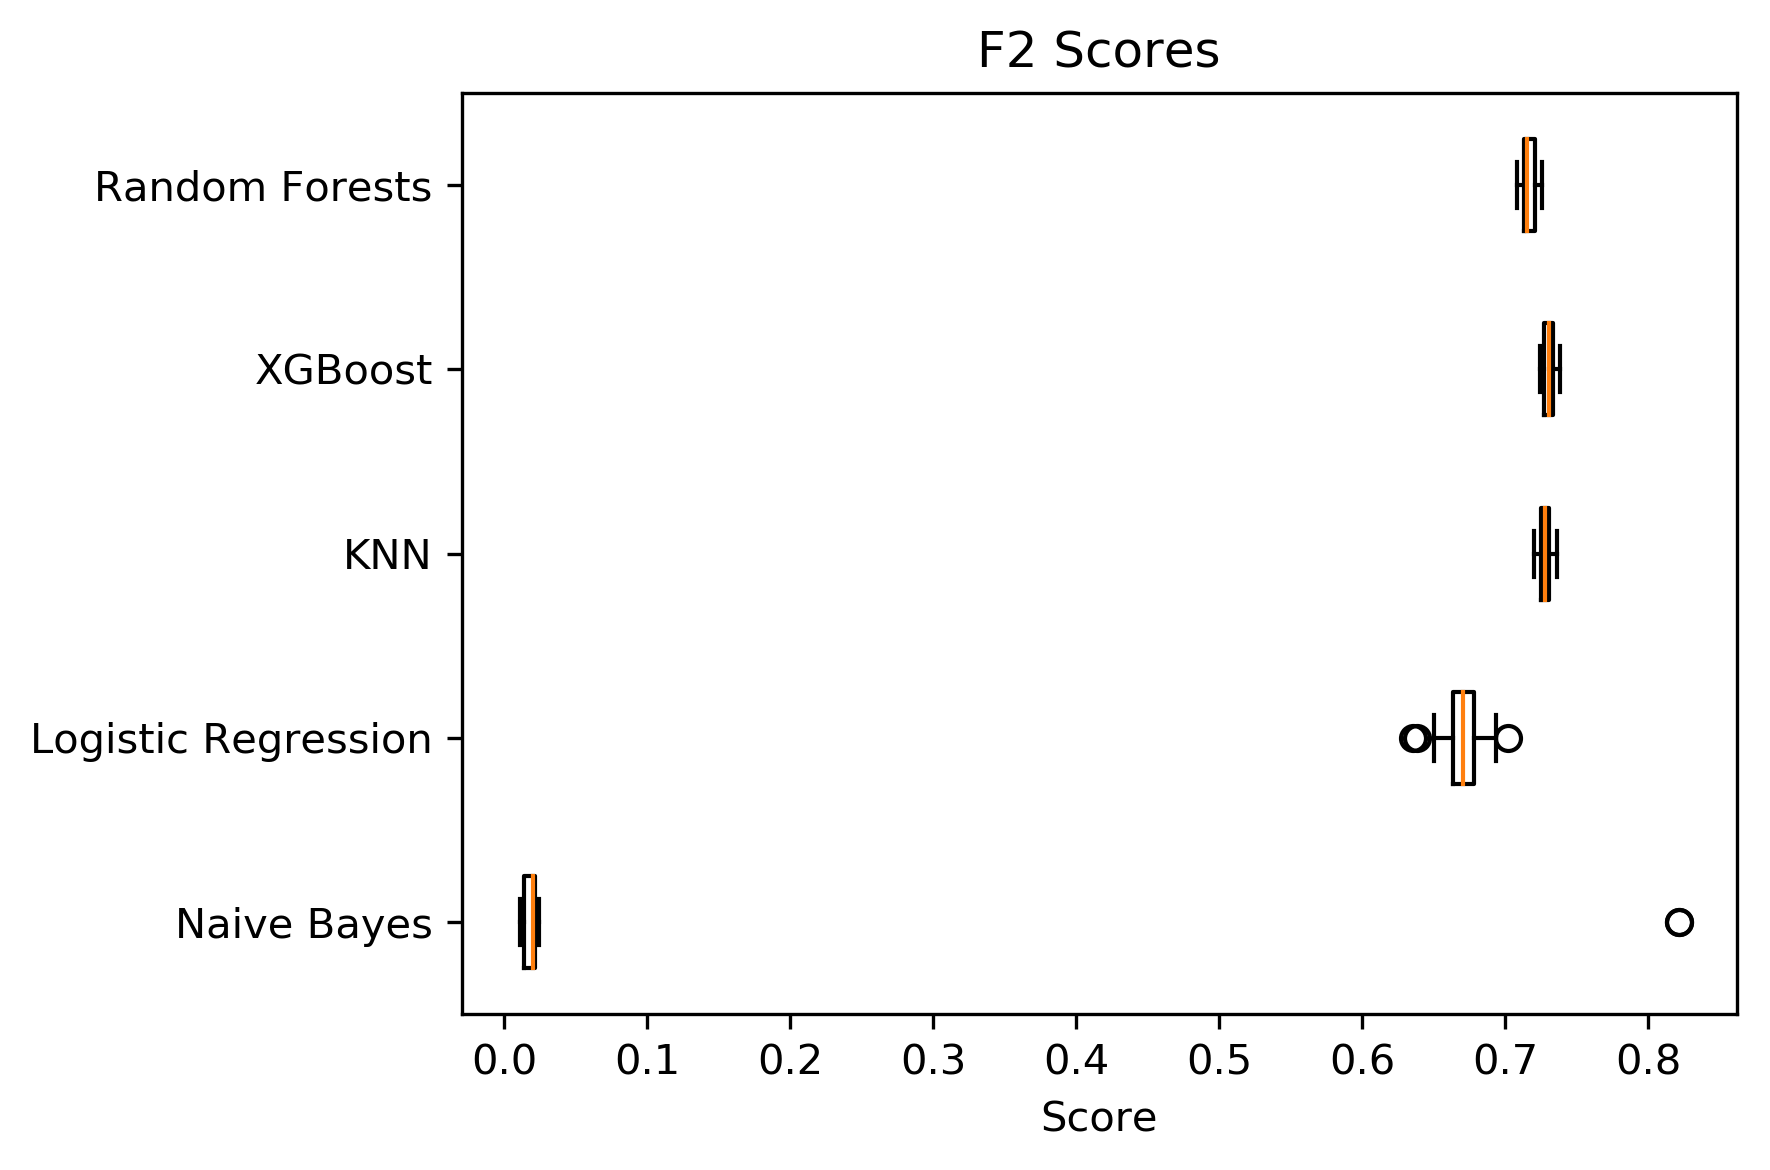

In [4]:
f2_scores = np.vstack((rf_f2, xgb_f2, knn_f2, lg_f2, nb_f2))[::-1].T
plt.boxplot(f2_scores, vert=False, labels=['Random Forests',"XGBoost", "KNN", "Logistic Regression","Naive Bayes"][::-1])
plt.title("F2 Scores")
plt.xlabel("Score")
plt.tight_layout()
plt.savefig("f2_boxplot.png", bbox_inches='tight')
plt.show()

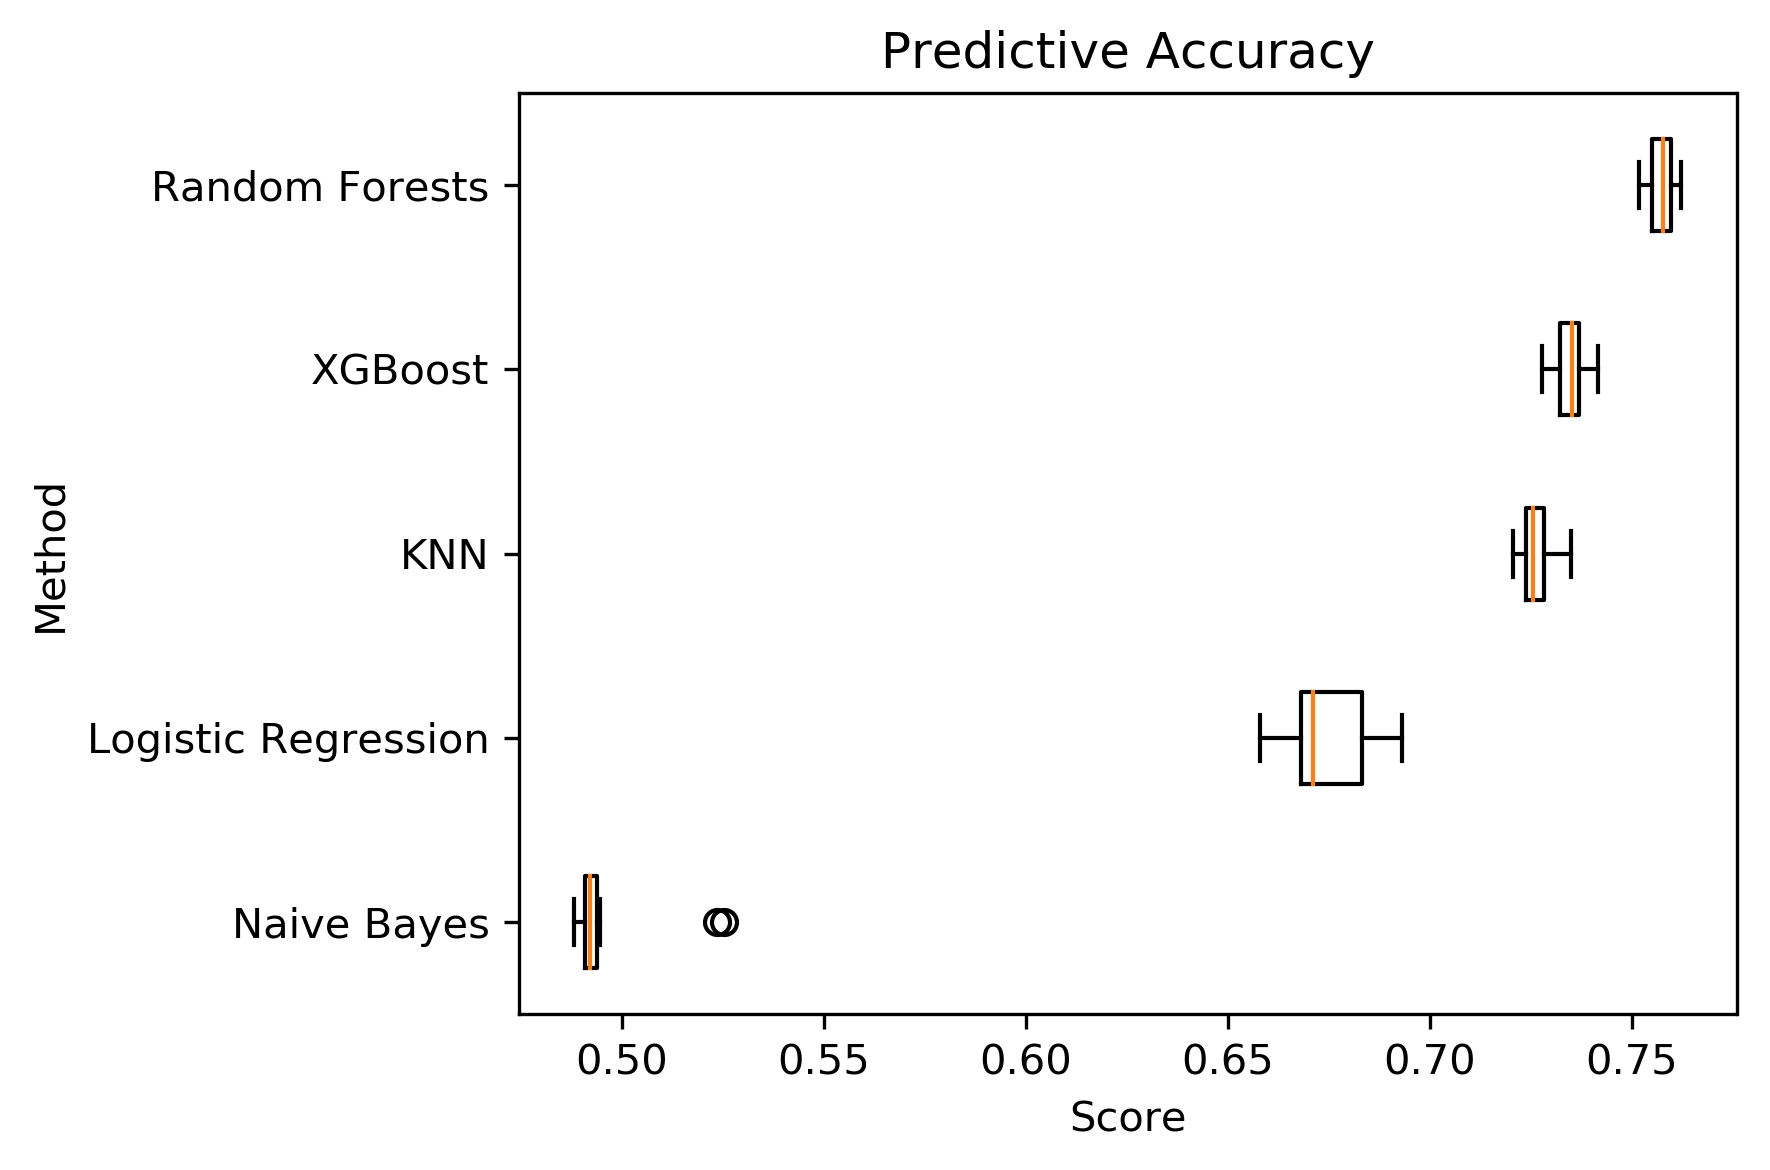

In [5]:
scores = np.vstack((rf_score, xgb_score, knn_score, lg_score, nb_score))[::-1].T
plt.boxplot(scores, vert=False, labels=['Random Forests',"XGBoost", "KNN","Logistic Regression","Naive Bayes"][::-1])
plt.title("Predictive Accuracy")
plt.xlabel("Score")
plt.ylabel("Method")
plt.tight_layout()
plt.savefig("pred_boxplot.png", bbox_inches='tight')
plt.show()

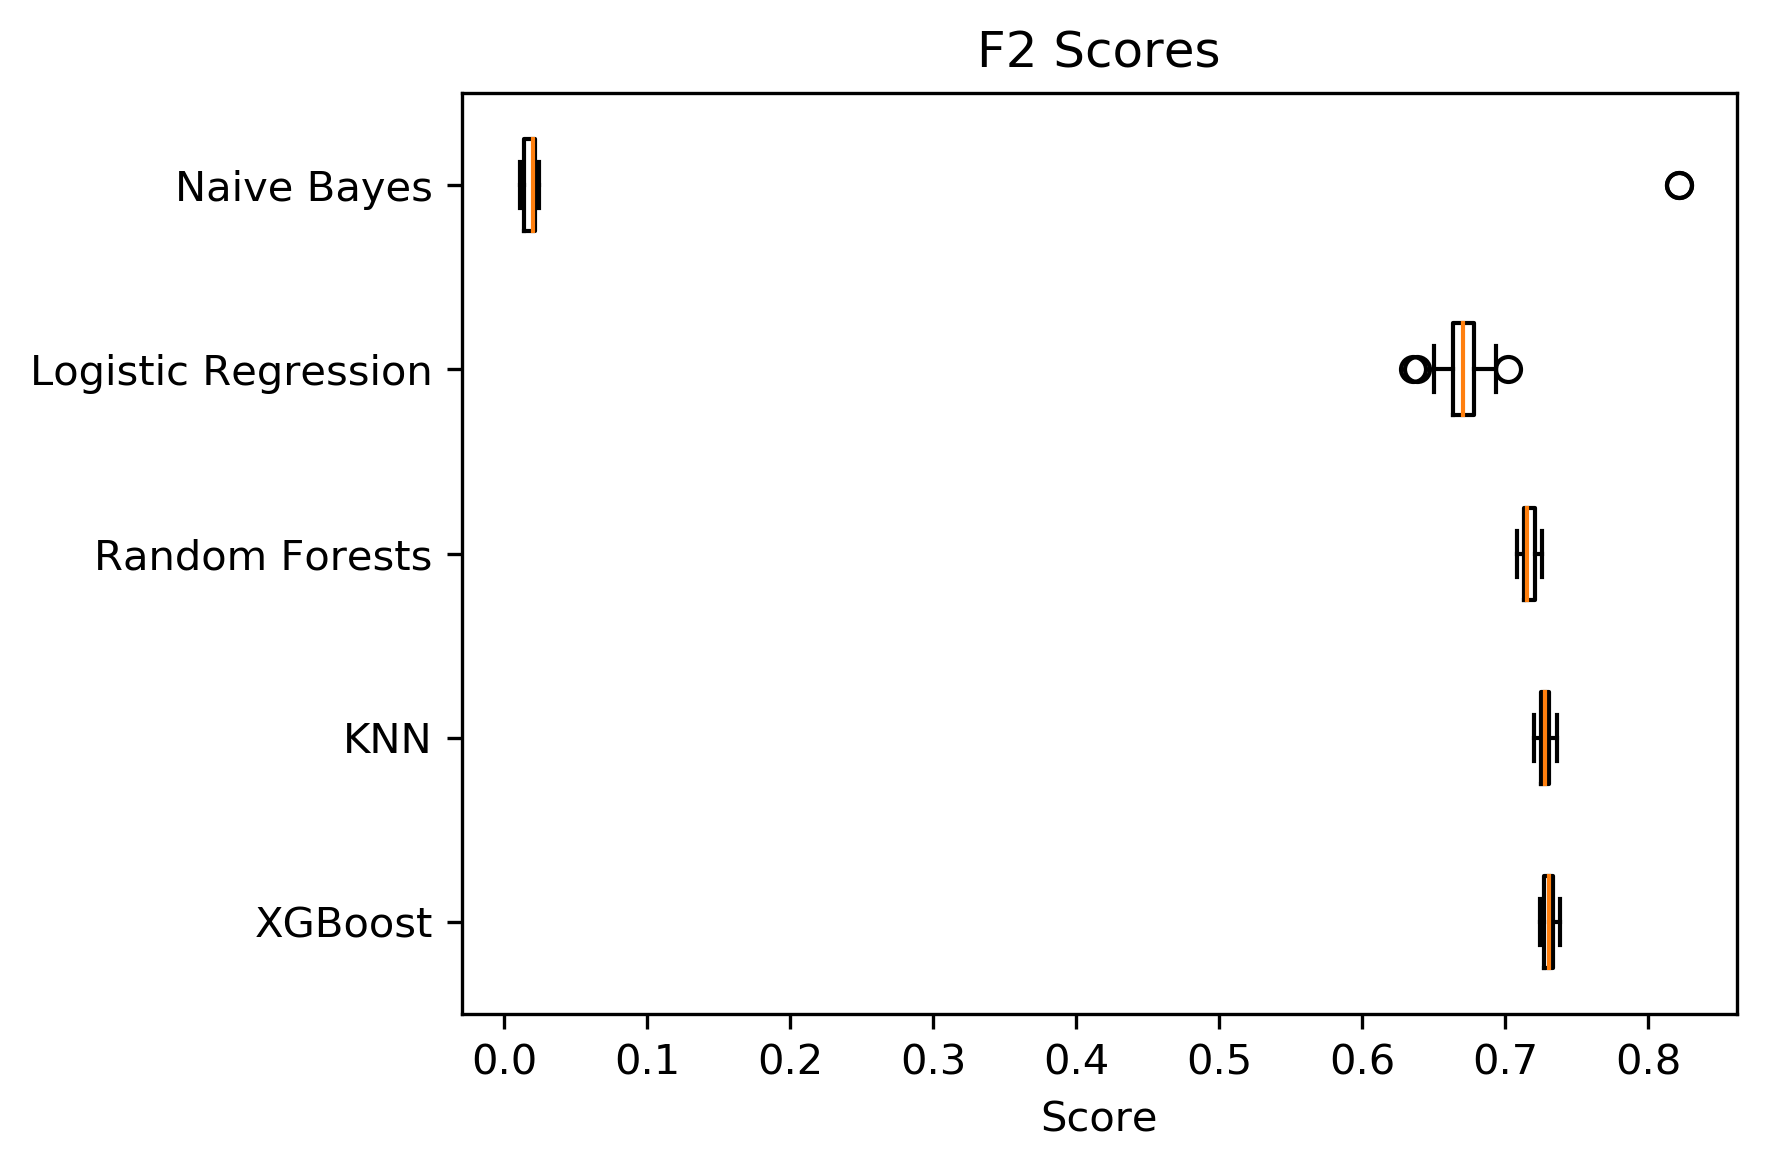

In [6]:
f2_scores = np.vstack((xgb_f2, knn_f2, rf_f2, lg_f2, nb_f2)).T
plt.boxplot(f2_scores, vert=False, labels=["XGBoost", "KNN", 'Random Forests',"Logistic Regression","Naive Bayes"])
plt.title("F2 Scores")
plt.xlabel("Score")
plt.tight_layout()
plt.show()

# Extra Trees

In [16]:
def plot_feature_importance(model, features, X, y):
    model.fit(X, y)
    features = np.array(list(X))
    # Find feature importance values
    important = model.feature_importances_
    indices = np.argsort(important)[::-1]

    # Find standard deviation
    std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)


    # See feature ranking and values
    print("Feature Ranking:")
    for f in range(20):
        print("%d. %s (%f)" % (f+1, features[indices[f]], important[indices[f]]))

    # Plot the figure
    plt.figure()
    plt.title("Feature Importance")
    plt.barh(range(15), important[indices[:15]][::-1], align="center")
    plt.yticks(range(15), features[indices[:15]][::-1])
    plt.ylim([-1, 15])
    plt.ylabel("Features")
    plt.xlabel("Impurity-Based Ranking")
    #plt.tight_layout()
    plt.savefig("feature_importance.png", bbox_inches='tight')
    plt.show()

In [67]:
##### PICKLED FILE DO NOT RUN #####

# # Grid Search
# train_set, X_test, y_test = train_test_split_50(data)

# mask_c = train_set.case_status_Denied==0
# mask_d = train_set.case_status_Denied==1
# d = len(train_set[mask_d])

# et_scores = []
# et_f2 = []
# # Set parameters
# for c in ['gini', 'entropy']:
#     for n in [40,60,80,100]:
#         # Run GridSearch
#         print(n, c)
#         pred = []
#         for i in range(5): 
#             sample = train_set[mask_c].sample(d).append(train_set[mask_d])

#             sample_X = sample.drop(['case_status_Denied'], axis=1)
#             sample_Y = sample['case_status_Denied']

#             forest = ExtraTreesClassifier(n_estimators=n, criterion=c)                
#             forest.fit(sample_X, sample_Y)
#             pred.append(forest.predict(X_test))

#         et_ensemble = np.sum(np.array(pred), axis=0) >=3

#         et_scores.append(np.sum(et_ensemble==np.array(y_test))/len(y_test))
#         print(fbeta_score(y_test,et_ensemble,2))
#         et_f2.append(fbeta_score(y_test,et_ensemble,2))

40 gini
0.730148602478
60 gini
0.738049791679
80 gini
0.737746958538
100 gini
0.743507757896
40 entropy
0.733064532719
60 entropy
0.740447659959
80 entropy
0.736702564946
100 entropy
0.736701581434


In [2]:
# with open('et_gridsearch_scores.pickle', 'wb') as handle:
#     pickle.dump(et_scores, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# with open('et_gridsearch_f2.pickle', 'wb') as handle:
#     pickle.dump(et_f2, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('et_gridsearch_scores.pickle', 'rb') as handle:
    et_scoresss = pickle.load(handle)
    
with open('et_gridsearch_f2.pickle', 'rb') as handle:
    et_f222 = pickle.load(handle)

    
et_params = []
for c in ['gini', 'entropy']:
    for n in [40,60,80,100]:
        et_params.append((n, c))

In [3]:
for i in range(len(et_params)):
    print(et_params[i])
    print(et_f222[i])
    print(et_scoresss[i])

(40, 'gini')
0.730148602478
0.746890927625
(60, 'gini')
0.738049791679
0.749796126402
(80, 'gini')
0.737746958538
0.74877675841
(100, 'gini')
0.743507757896
0.752854230377
(40, 'entropy')
0.733064532719
0.748878695209
(60, 'entropy')
0.740447659959
0.754689092762
(80, 'entropy')
0.736702564946
0.750866462793
(100, 'entropy')
0.736701581434
0.749643221203


In [6]:
np.mean(et_scoresss)

0.75029943934760446

Feature Ranking:
1. pw_amount_new (0.154331)
2. employer_num_employees (0.034525)
3. class_of_admission_H-1B (0.023466)
4. recr_info_professional_occ_True (0.019069)
5. country_of_citizenship_INDIA (0.016605)
6. job_info_foreign_ed_True (0.016002)
7. used_agency (0.015393)
8. decision_date_2014-01-01 (0.014879)
9. pw_unit_of_pay_9089_Year (0.013807)
10. job_info_experience_True (0.012893)
11. job_info_experience_num_months (0.012510)
12. decision_date_2013-01-01 (0.012006)
13. naics_title_Custom Computer Programming Services (0.011117)
14. employer_state_CA (0.010318)
15. naics_title_Elementary and Secondary Schools (0.009647)
16. decision_date_2016-01-01 (0.009329)
17. employer_state_TX (0.009231)
18. foreign_worker_info_education_Bachelor's (0.008946)
19. pw_unit_of_pay_9089_Hour (0.008305)
20. naics_title_Computer Systems Design Services (0.008283)


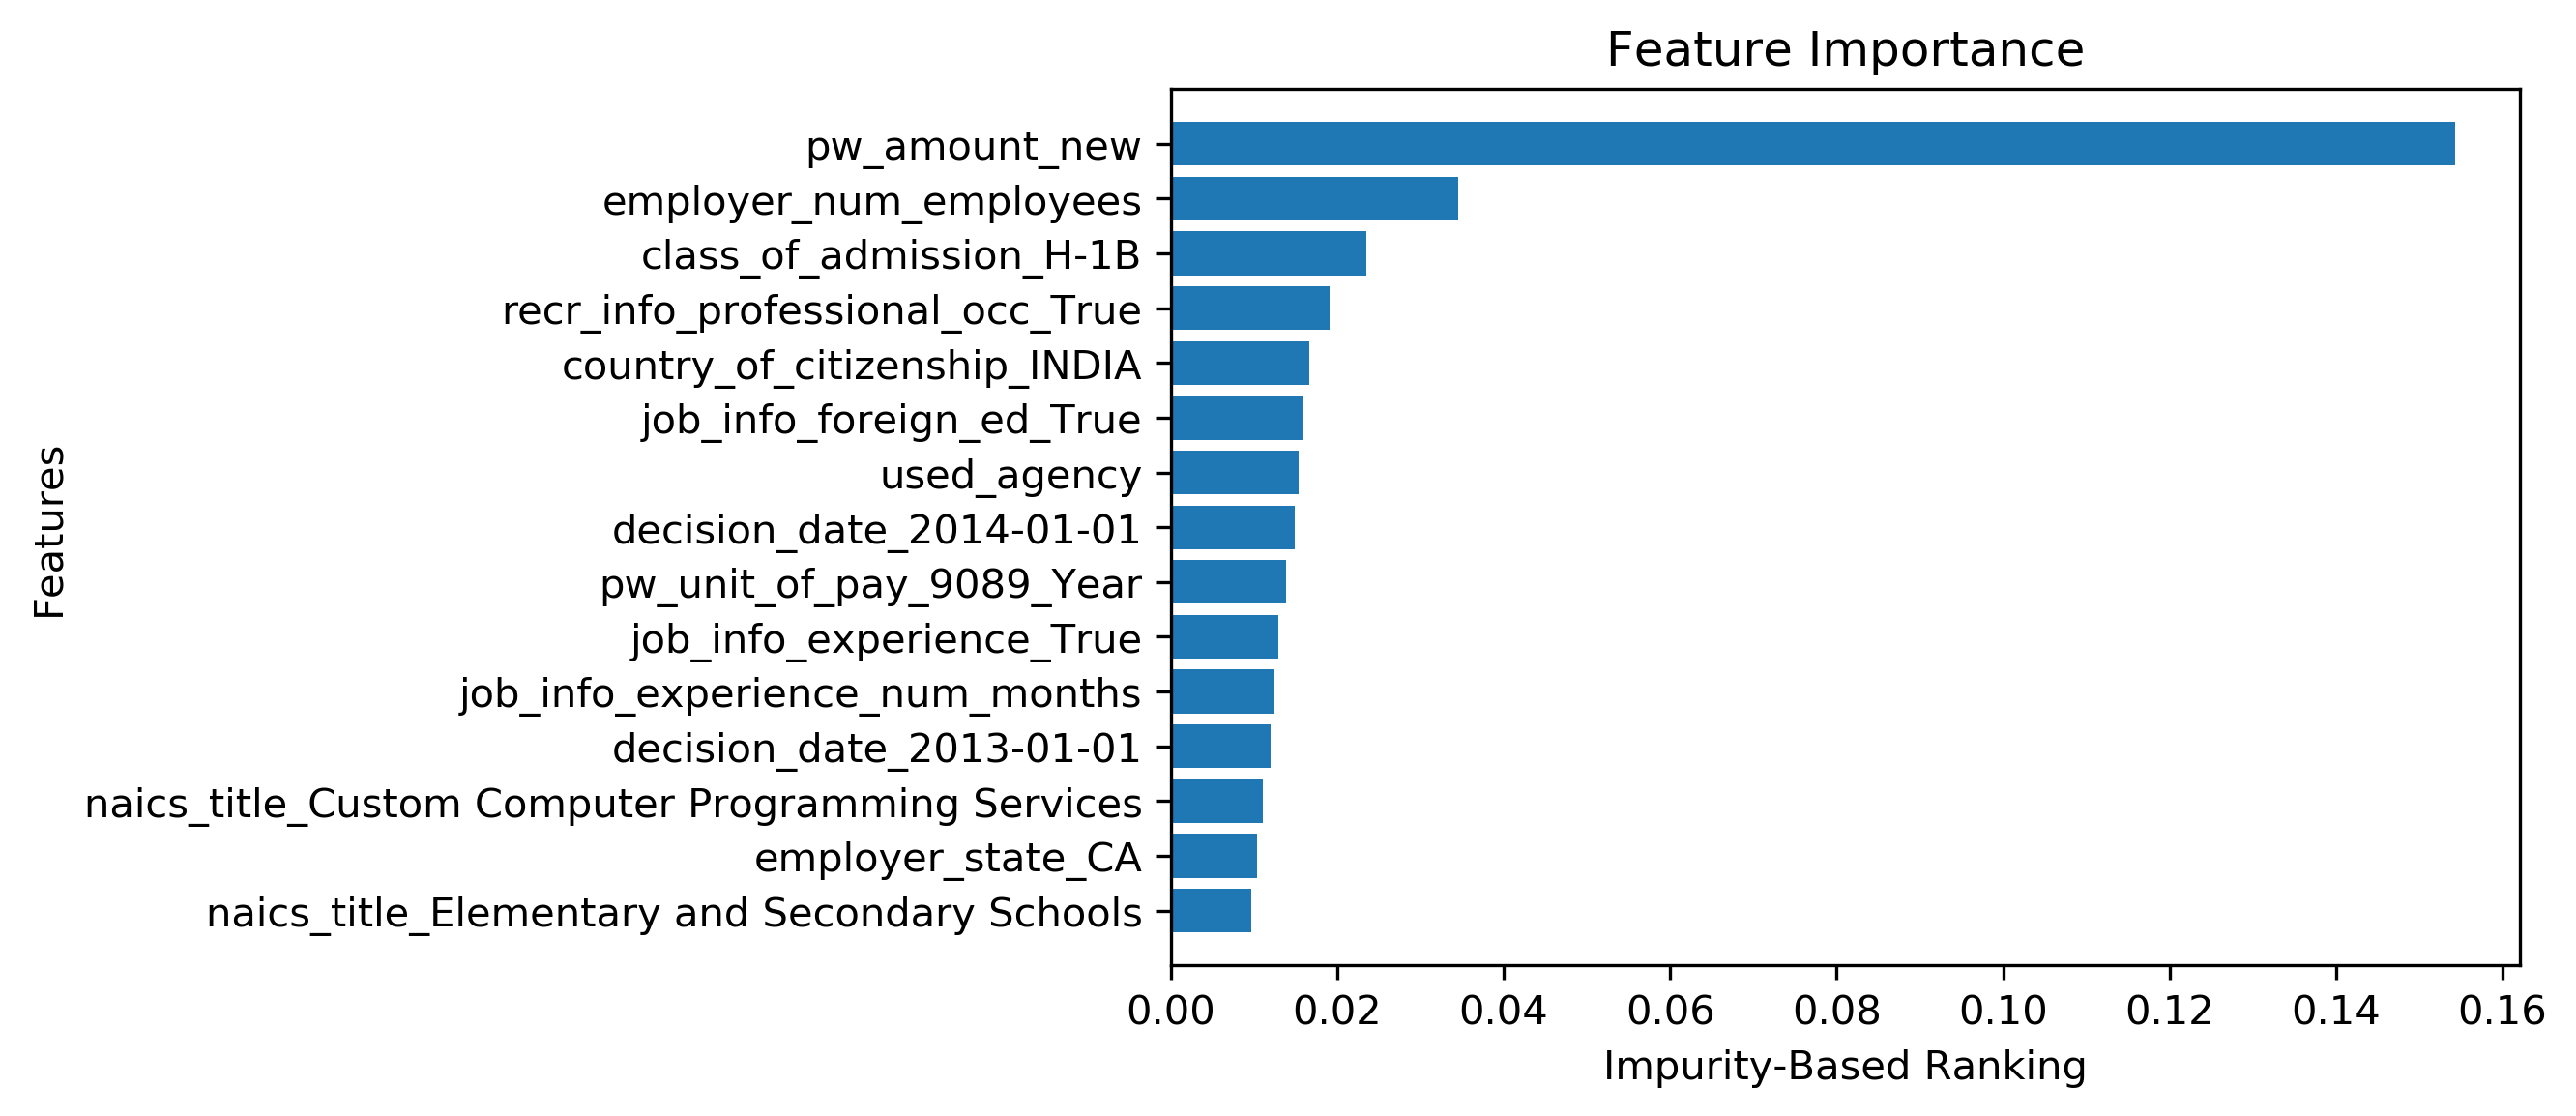

In [85]:
# Choose best parameters from grid search
forest = ExtraTreesClassifier(n_estimators=100, criterion='gini') 
features = np.array(list(sample_X))
plot_feature_importance(forest, features, sample_X, sample_Y)

# Random Forest

In [86]:
##### PICKLED FILE DO NOT RUN #####

# # Random Forest Grid Search
# train_set, X_test, y_test = train_test_split_50(data)

# mask_c = train_set.case_status_Denied==0
# mask_d = train_set.case_status_Denied==1
# d = len(train_set[mask_d])

# rf_scores = []
# rf_f2 = []
# # Set parameters
# for c in ['gini', 'entropy']:
#     for n in [40,60,80,100]:
#         # Run GridSearch
#         print(n, c)
#         pred = []
#         for i in range(5): 
#             sample = train_set[mask_c].sample(d).append(train_set[mask_d])

#             sample_X = sample.drop(['case_status_Denied'], axis=1)
#             sample_Y = sample['case_status_Denied']

#             forest = RandomForestClassifier(n_estimators=n, criterion=c)                
#             forest.fit(sample_X, sample_Y)
#             pred.append(forest.predict(X_test))

#         rf_ensemble = np.sum(np.array(pred), axis=0) >=3

#         rf_scores.append(np.sum(rf_ensemble==np.array(y_test))/len(y_test))
#         print(fbeta_score(y_test,rf_ensemble,2))
#         rf_f2.append(fbeta_score(y_test,rf_ensemble,2))

40 gini
0.736869260138
60 gini
0.738904578343
80 gini
0.740271772699
100 gini
0.74463497279
40 entropy
0.739034545305
60 entropy
0.738622310166
80 entropy
0.737926063227
100 entropy
0.7399934113


In [35]:
# with open('rf_gridsearch_scores.pickle', 'wb') as handle:
#     pickle.dump(rf_scores, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# with open('rf_gridsearch_f2.pickle', 'wb') as handle:
#     pickle.dump(rf_f2, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
rf_params = []
for c in ['gini', 'entropy']:
    for n in [40,60,80,100]:
        rf_params.append((n, c))

Feature Ranking:
1. pw_amount_new (0.182488)
2. employer_num_employees (0.060814)
3. class_of_admission_H-1B (0.021947)
4. recr_info_professional_occ_True (0.018741)
5. job_info_experience_num_months (0.016900)
6. country_of_citizenship_INDIA (0.015528)
7. job_info_foreign_ed_True (0.014865)
8. decision_date_2014-01-01 (0.013814)
9. pw_unit_of_pay_9089_Year (0.013545)
10. used_agency (0.013337)
11. naics_title_Custom Computer Programming Services (0.011746)
12. decision_date_2013-01-01 (0.011279)
13. employer_state_CA (0.010077)
14. job_info_experience_True (0.009906)
15. decision_date_2016-01-01 (0.009349)
16. employer_state_TX (0.009018)
17. naics_title_Computer Systems Design Services (0.008618)
18. naics_title_Elementary and Secondary Schools (0.007800)
19. foreign_worker_info_education_Master's (0.007771)
20. foreign_worker_info_education_Bachelor's (0.007696)


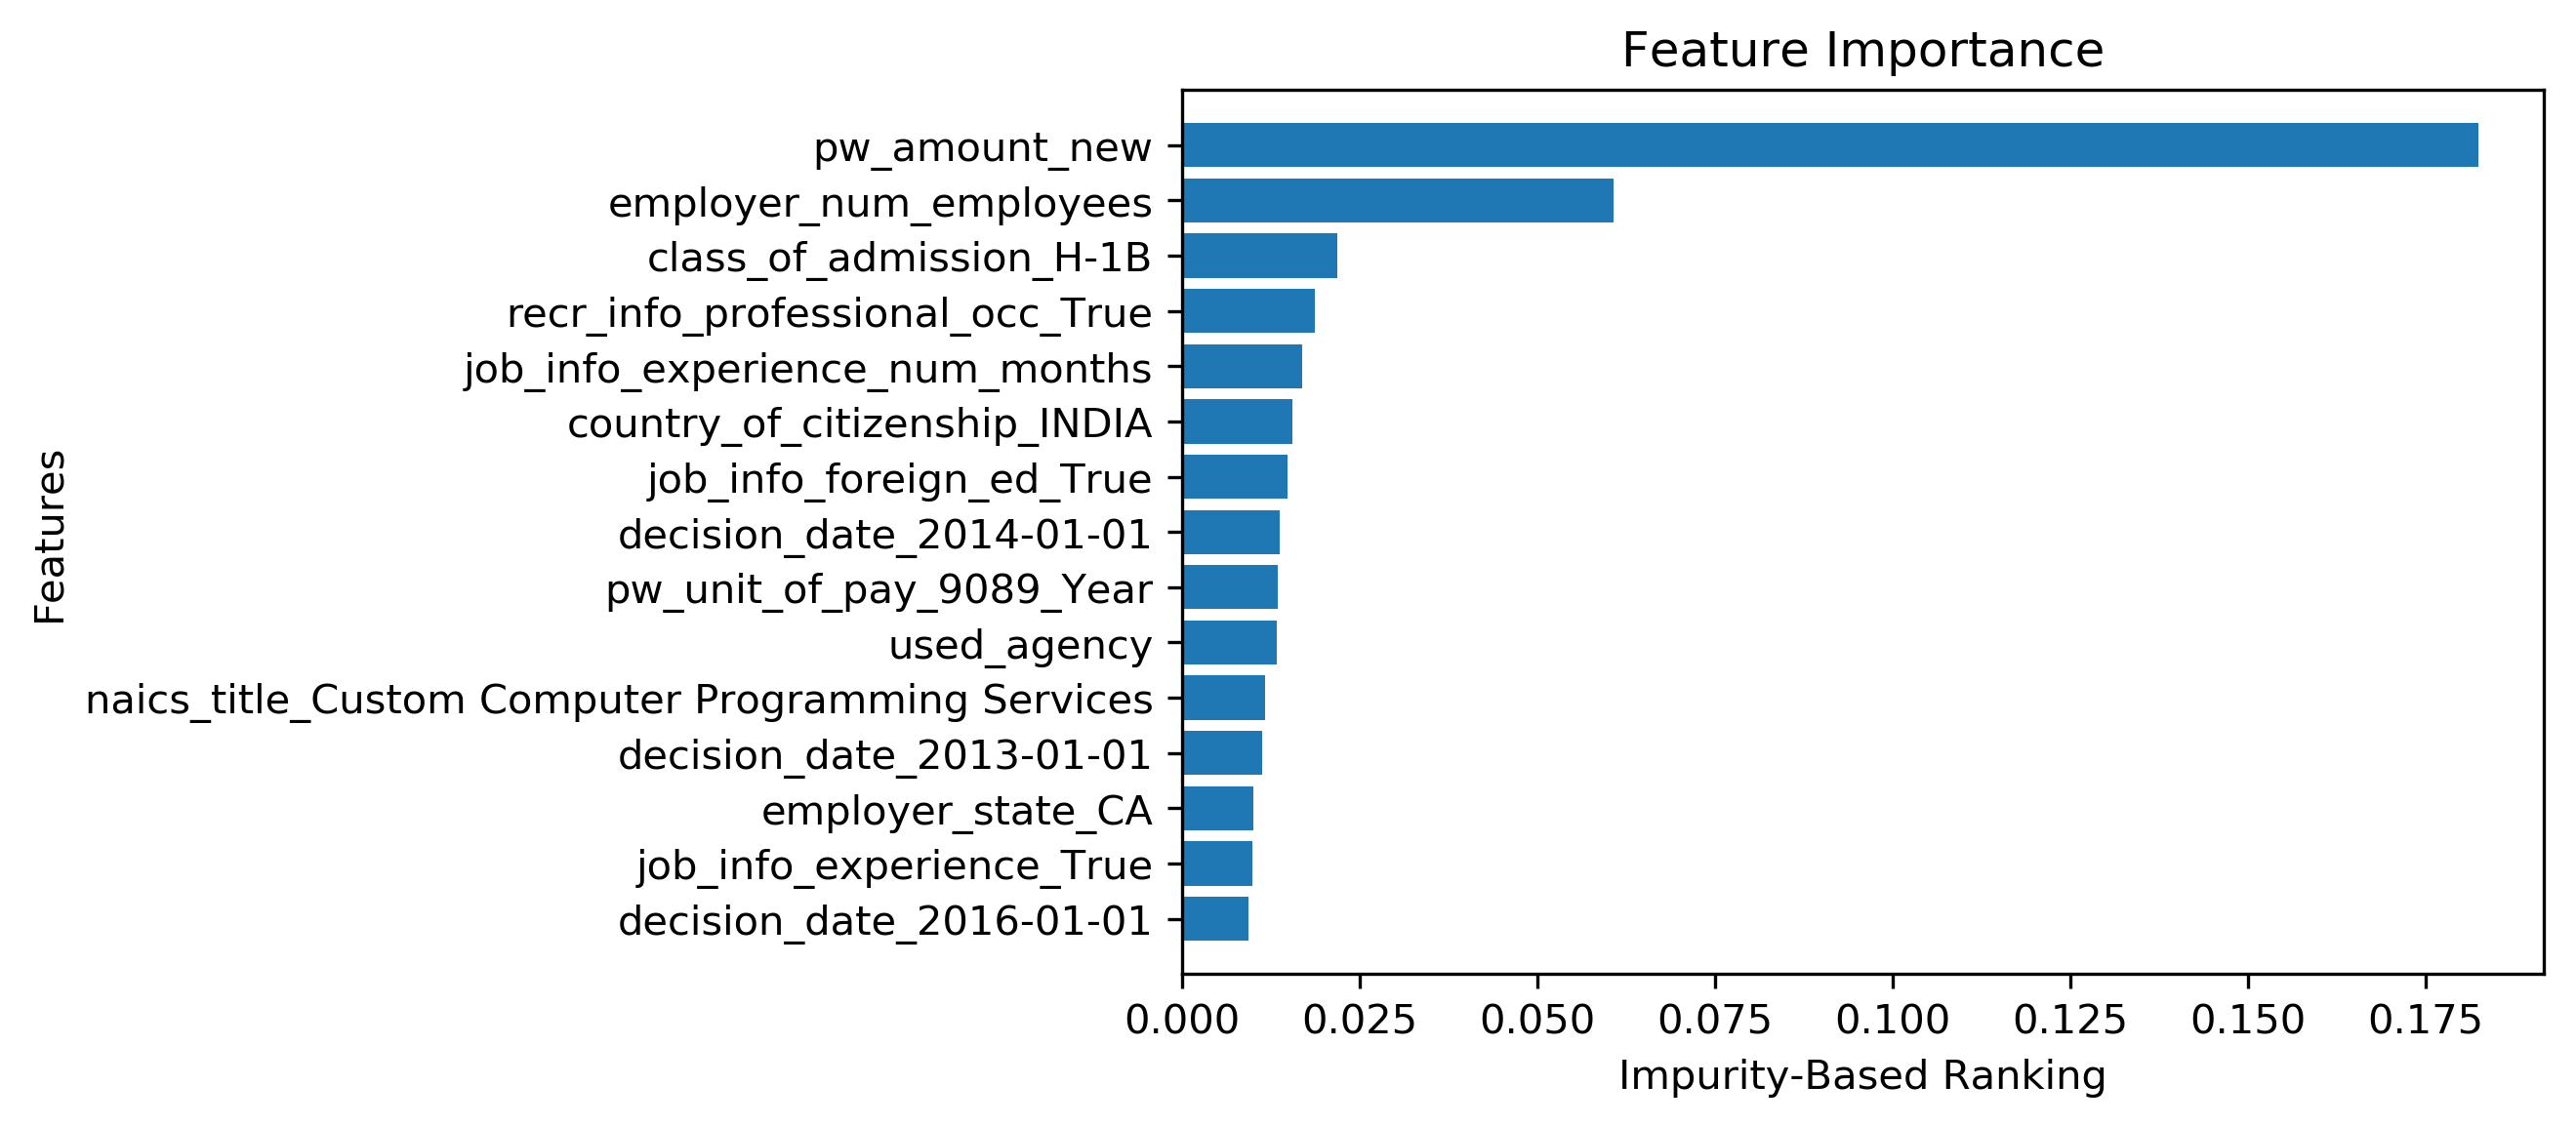

In [89]:
# Choose best parameters from grid search
model = RandomForestClassifier(n_estimators=100, criterion='gini')
features = np.array(list(sample_X))
plot_feature_importance(model, features, sample_X, sample_Y)

### Numerical Values Dropped

Feature Ranking:
1. class_of_admission_H-1B (0.028632)
2. recr_info_professional_occ_True (0.021791)
3. country_of_citizenship_INDIA (0.021085)
4. job_info_foreign_ed_True (0.020618)
5. used_agency (0.018830)
6. job_info_experience_True (0.018427)
7. decision_date_2014-01-01 (0.018010)
8. naics_title_Custom Computer Programming Services (0.014742)
9. decision_date_2013-01-01 (0.013387)
10. employer_state_CA (0.013341)
11. pw_unit_of_pay_9089_Year (0.012998)
12. decision_date_2016-01-01 (0.011917)
13. employer_state_TX (0.011702)
14. naics_title_Computer Systems Design Services (0.011304)
15. foreign_worker_info_education_Bachelor's (0.011163)
16. foreign_worker_info_education_Master's (0.010451)
17. decision_date_2015-01-01 (0.010154)
18. naics_title_Elementary and Secondary Schools (0.009647)
19. pw_unit_of_pay_9089_Hour (0.009358)
20. employer_state_NJ (0.008799)


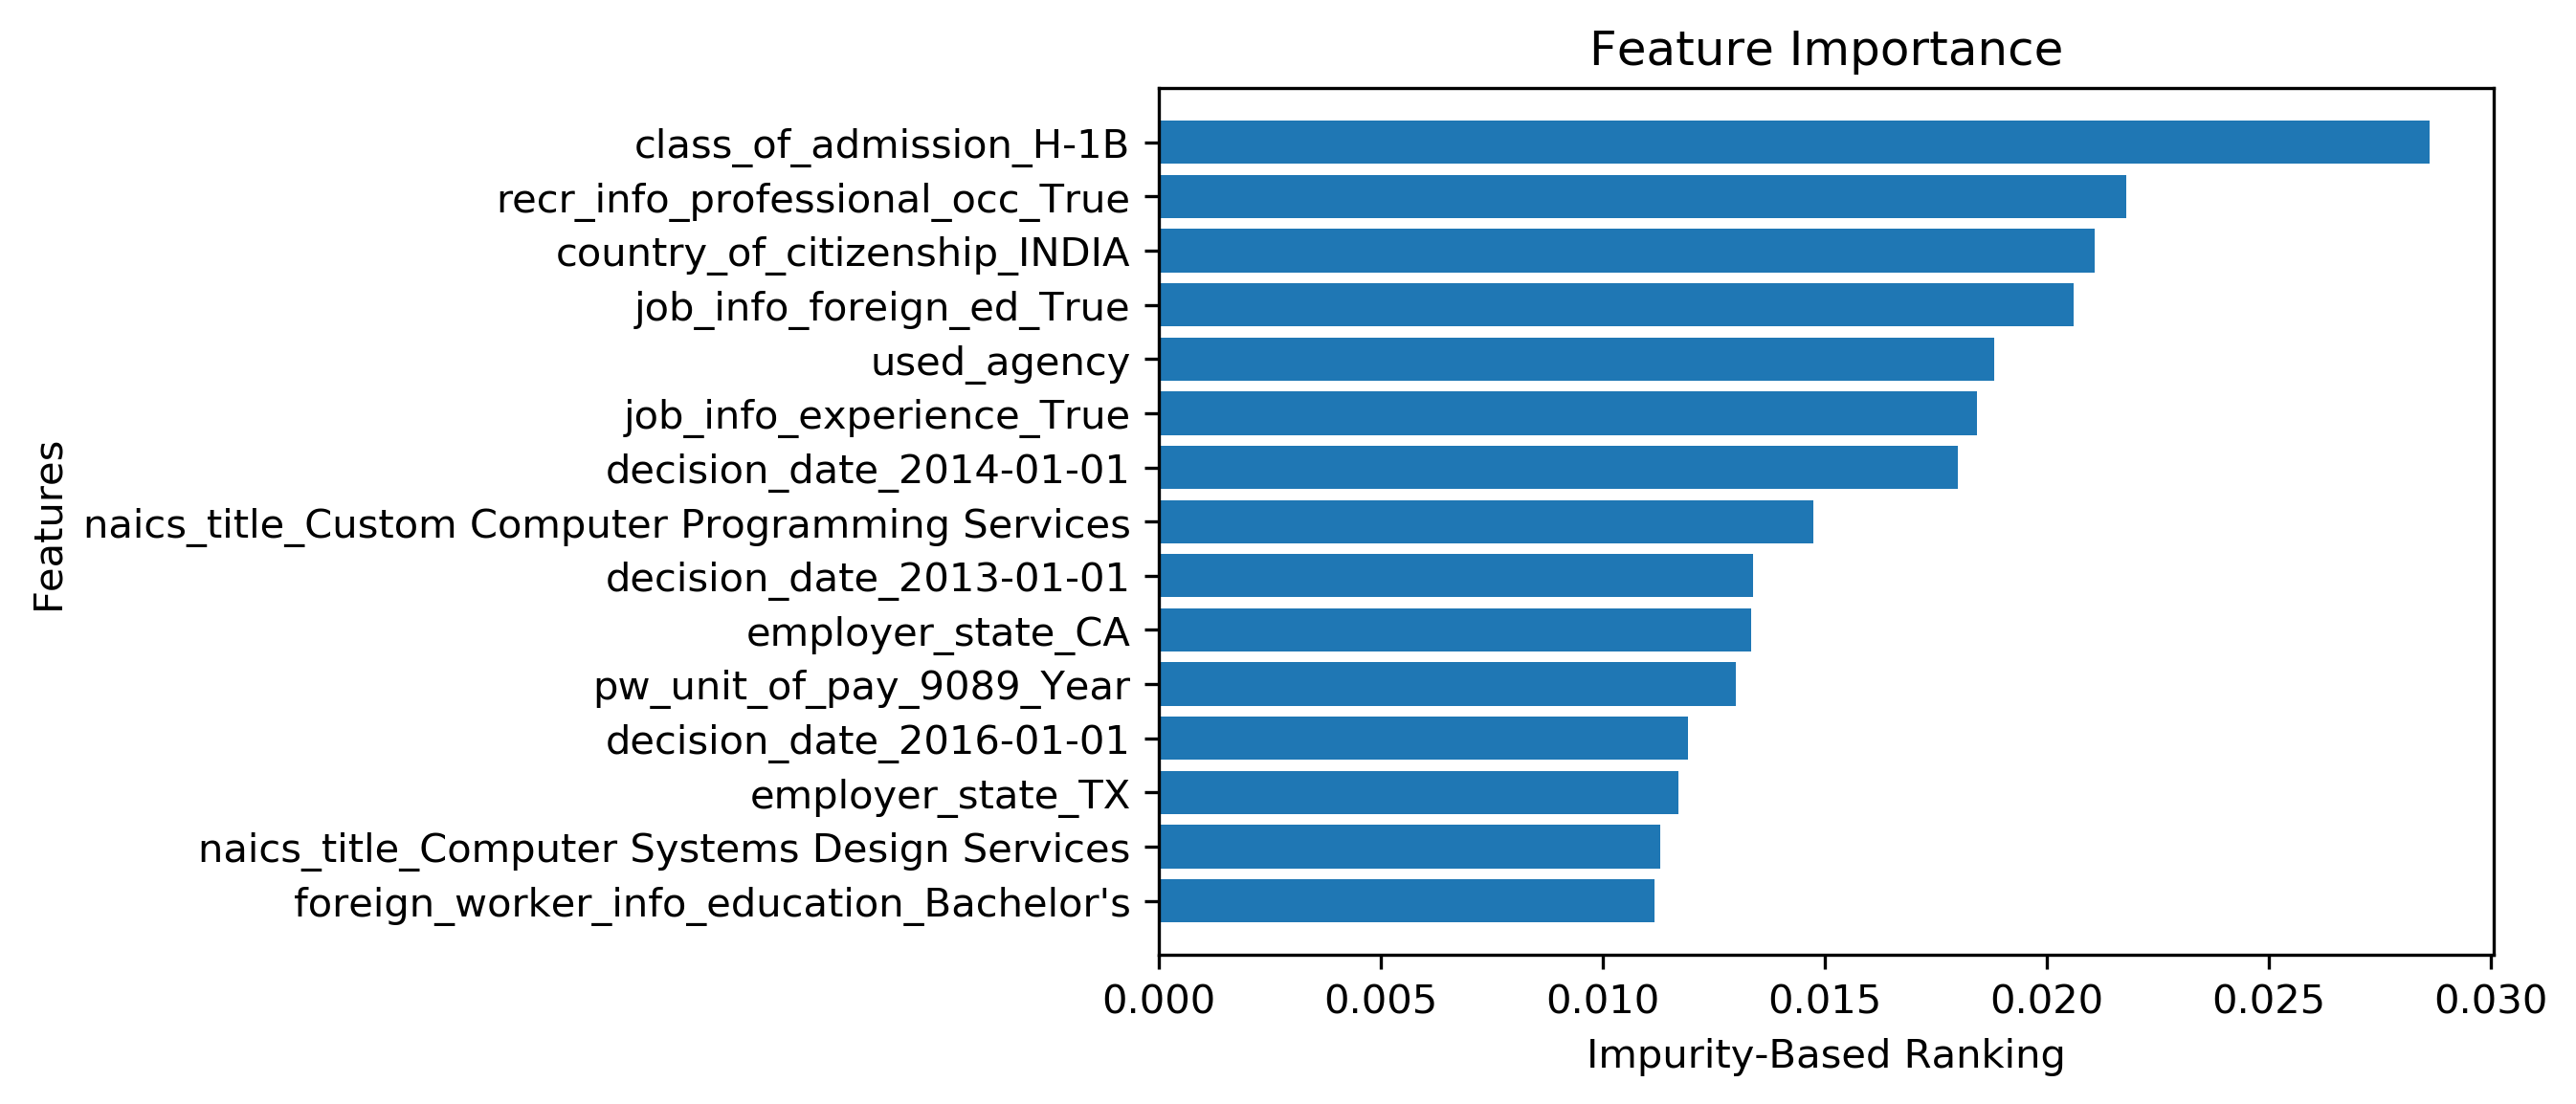

In [17]:
droplist = ['pw_amount_new','employer_num_employees','job_info_experience_num_months']
train_set, X_test,y_test = train_test_split_50(data.drop(droplist,axis=1))


mask_c = train_set.case_status_Denied==0
mask_d = train_set.case_status_Denied==1
d = len(train_set[mask_d])

rf_scores = []
rf_f2 = []

sample = train_set[mask_c].sample(d).append(train_set[mask_d])

sample_X = sample.drop(['case_status_Denied'], axis=1)
sample_Y = sample['case_status_Denied']

model = RandomForestClassifier(n_estimators=100, criterion='gini')
features = np.array(list(sample_X))
plot_feature_importance(model, features, sample_X, sample_Y)

# XGBoost Feature Importance

In [6]:
with open('xg_feature.pickle', 'rb') as handle:
    xg_feature = pickle.load(handle)

In [9]:
xg_feature

,feature,fscore
0,foreign_worker_yr_rel_edu_completed_2010-01-01,0.002079
1,employer_yr_estab_1923-01-01,0.002079
2,naics_title_Internet Service Providers and Web...,0.002079
3,employer_yr_estab_1977-01-01,0.002079
4,naics_title_Fresh and Frozen Seafood Processing,0.002079
5,employer_yr_estab_1999-01-01,0.002079
6,naics_title_Book Stores,0.002079
7,foreign_worker_yr_rel_edu_completed_2011-01-01,0.002079
8,naics_title_Engineering Services,0.002079
9,employer_yr_estab_2003-01-01,0.002079


Feature Ranking:
1. foreign_worker_yr_rel_edu_completed_2010-01-01 (0.002079)
2. decision_date_2015-01-01 (0.002079)
3. employer_yr_estab_2005-01-01 (0.002079)
4. employer_yr_estab_1941-01-01 (0.002079)
5. employer_yr_estab_1978-01-01 (0.002079)
6. employer_state_OH (0.002079)
7. foreign_worker_yr_rel_edu_completed_2002-01-01 (0.002079)
8. refile_True (0.002079)
9. employer_state_NC (0.002079)
10. naics_title_Pharmacies and Drug Stores (0.002079)
11. country_of_citizenship_PHILIPPINES (0.002079)
12. foreign_worker_yr_rel_edu_completed_1999-01-01 (0.002079)
13. country_of_citizenship_UNITED KINGDOM (0.002079)
14. naics_title_Junior Colleges (0.002079)
15. naics_title_Casino Hotels (0.002079)
16. class_of_admission_B-2 (0.002079)
17. naics_title_Full-Service Restaurants (0.002079)
18. country_of_citizenship_POLAND (0.002079)
19. employer_yr_estab_2001-01-01 (0.002079)
20. naics_title_Educational Support Services (0.002079)


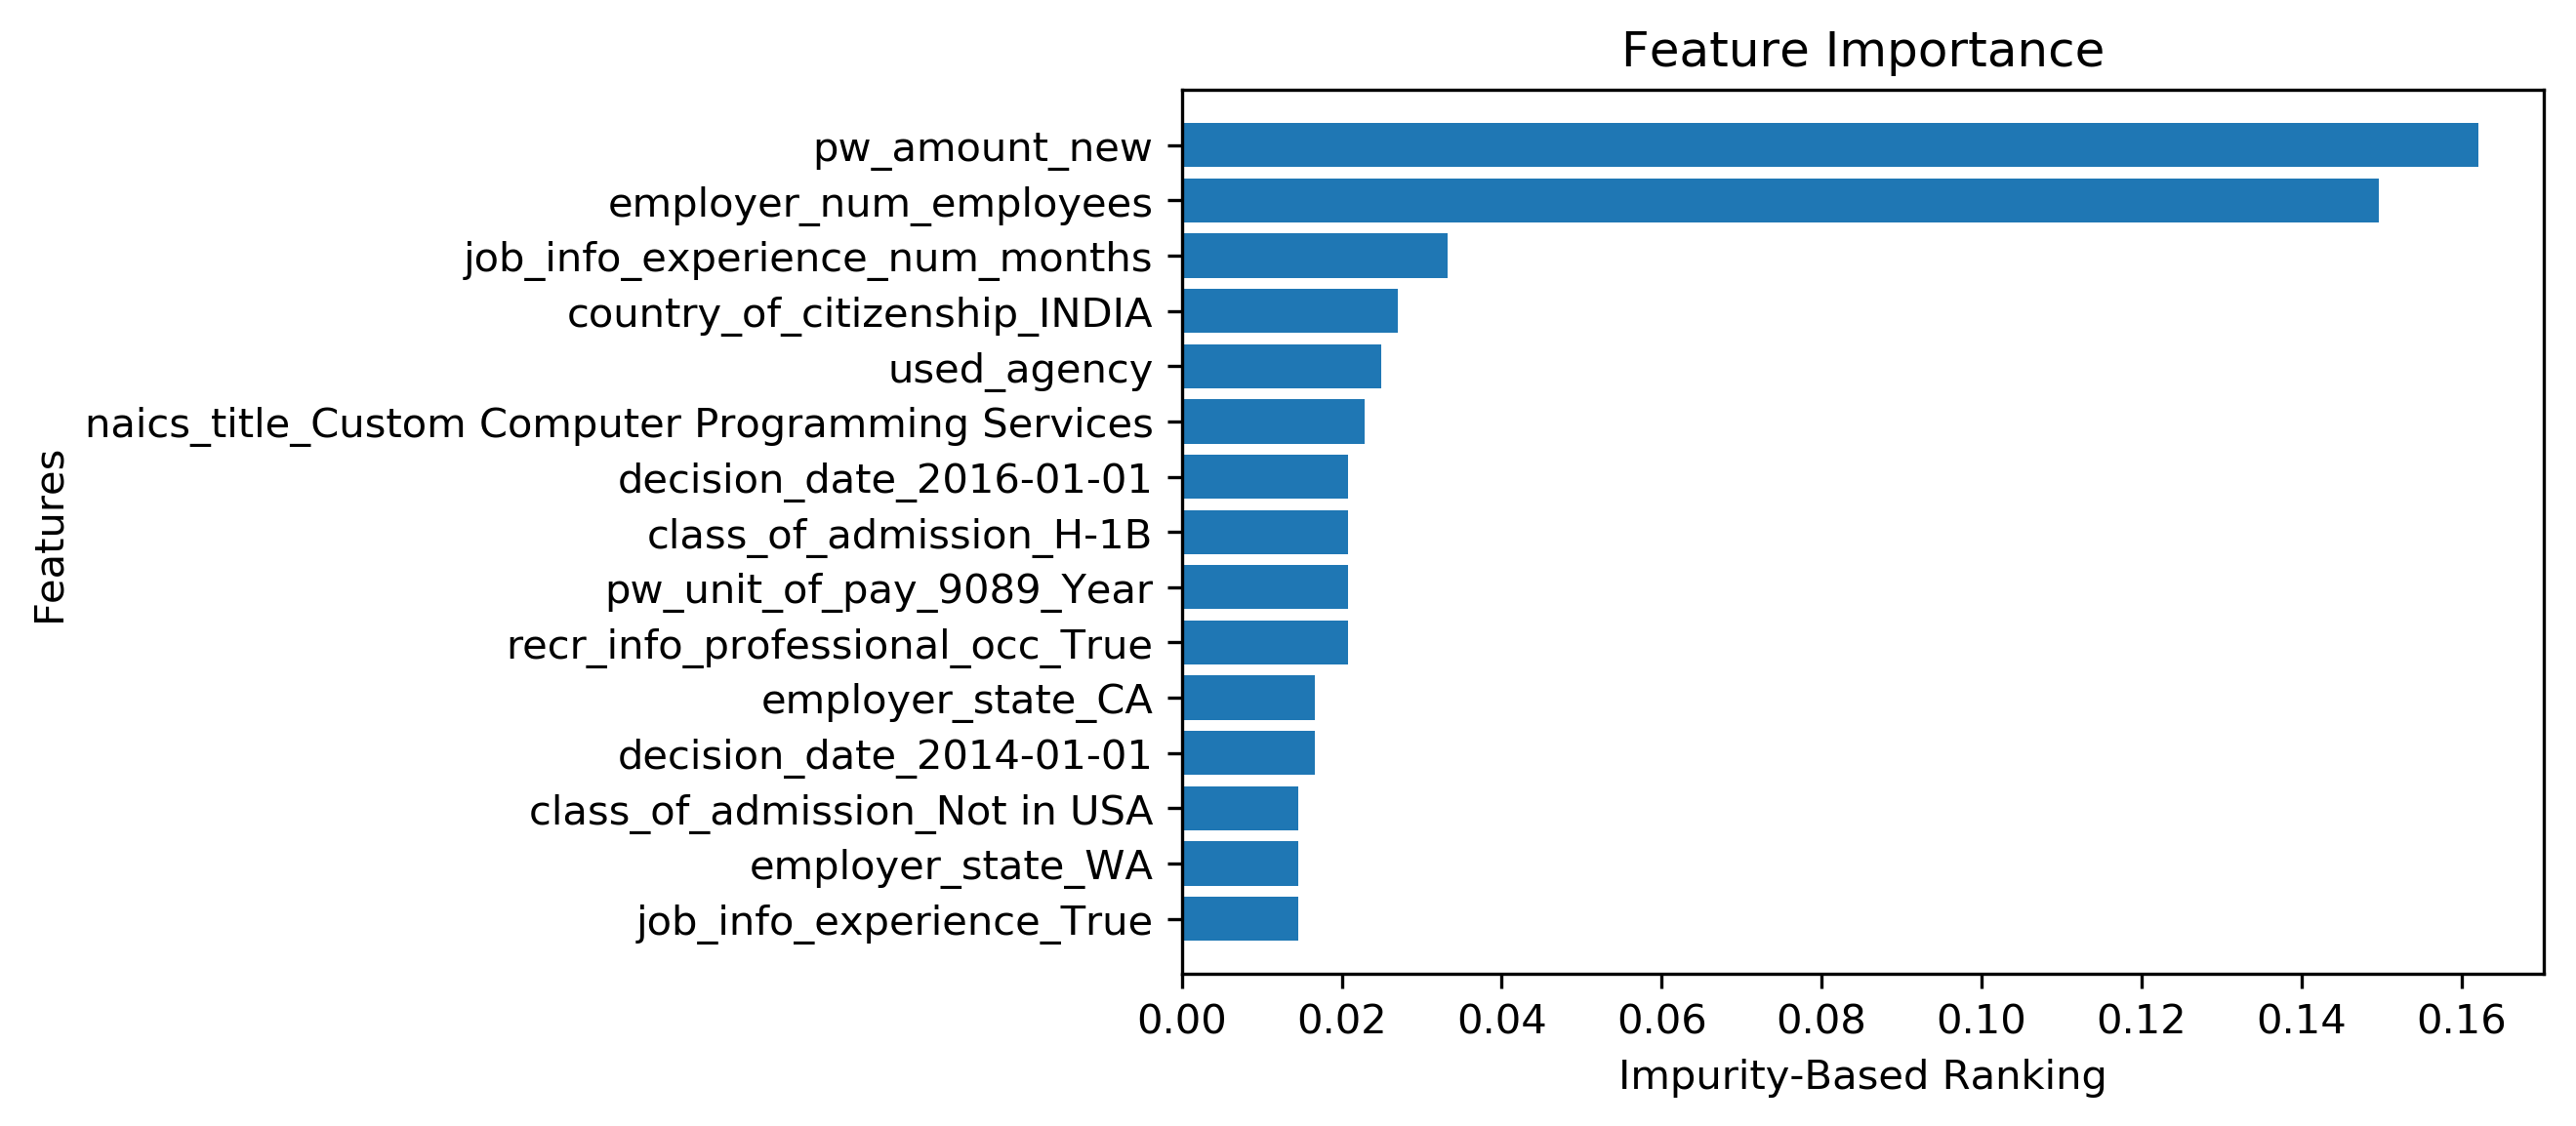

In [17]:
features = xg_feature.feature
indices = np.argsort(xg_feature.fscore)[::-1]

print("Feature Ranking:")
for f in range(20):
    print("%d. %s (%f)" % (f+1, features[indices[f]], xg_feature.fscore[indices[f]]))

# Plot the figure
plt.figure()
plt.title("Feature Importance")
plt.barh(range(15), xg_feature.fscore[indices[:15]][::-1], align="center")
plt.yticks(range(15), features[indices[:15]][::-1])
plt.ylim([-1, 15])
plt.ylabel("Features")
plt.xlabel("Impurity-Based Ranking")
#plt.tight_layout()
plt.savefig("feature_importance.png", bbox_inches='tight')
plt.show()

# Confusion Matrix

In [23]:
# Random Forest Grid Search
train_set, X_test, y_test = train_test_split_50(data)

mask_c = train_set.case_status_Denied==0
mask_d = train_set.case_status_Denied==1
d = len(train_set[mask_d])

pred = []
for i in range(5): 
    sample = train_set[mask_c].sample(d).append(train_set[mask_d])

    sample_X = sample.drop(['case_status_Denied'], axis=1)
    sample_Y = sample['case_status_Denied']

    forest = RandomForestClassifier(n_estimators=100, criterion='gini')                
    forest.fit(sample_X, sample_Y)
    pred.append(forest.predict(X_test))

rf_pred = np.sum(np.array(pred), axis=0) >=3

In [24]:
confusion_matrix(y_test, rf_pred)

array([[7739, 2071],
       [2651, 7159]])

In [11]:
with open('knn_gridsearch_scores.pickle', 'rb') as handle:
    knn_scoresss = pickle.load(handle)
    
with open('knn_gridsearch_f2.pickle', 'rb') as handle:
    knn_f222 = pickle.load(handle)

In [28]:
for i in range(len(knn_params)):
    print(knn_params[i])
    print(knn_f222[i])
    print(knn_scoresss[i])

(5, 'uniform', 'auto')
0.725337899823
0.725229357798
(10, 'uniform', 'auto')
0.681302201579
0.719826707441
(20, 'uniform', 'auto')
0.697391734311
0.71620795107
(5, 'distance', 'auto')
0.730836698894
0.731702344546
(10, 'distance', 'auto')
0.731978535431
0.733384301733
(20, 'distance', 'auto')
0.727112999775
0.730835881753
(5, 'uniform', 'brute')
0.725183860875
0.718960244648
(10, 'uniform', 'brute')
0.679683278607
0.714271151886
(20, 'uniform', 'brute')
0.693986820428
0.712028542304
(5, 'distance', 'brute')
0.723401656863
0.720540265036
(10, 'distance', 'brute')
0.718465473146
0.724821610601
(20, 'distance', 'brute')
0.721826312458
0.724617737003


In [12]:
np.mean(knn_scoresss)

0.72270217465171582

In [13]:
np.mean(knn_f222)

0.71304228934914871

In [43]:
a = np.argmax(et_f222)
b = np.argmax(et_scoresss)

In [44]:
a


3

In [45]:
b

5

In [8]:
with open('rf_gridsearch_scores.pickle', 'rb') as handle:
    rf_scoresss = pickle.load(handle)
    
with open('rf_gridsearch_f2.pickle', 'rb') as handle:
    rf_f222 = pickle.load(handle)

In [42]:
for i in range(len(rf_params)):
    print(rf_params[i])
    print(rf_f222[i])
    print(rf_scoresss[i])

(40, 'gini')
0.730148602478
0.746890927625
(60, 'gini')
0.738049791679
0.749796126402
(80, 'gini')
0.737746958538
0.74877675841
(100, 'gini')
0.743507757896
0.752854230377
(40, 'entropy')
0.733064532719
0.748878695209
(60, 'entropy')
0.740447659959
0.754689092762
(80, 'entropy')
0.736702564946
0.750866462793
(100, 'entropy')
0.736701581434
0.749643221203


In [40]:
with open('et_gridsearch_scores.pickle', 'rb') as handle:
    et_scoresss = pickle.load(handle)
    
with open('et_gridsearch_f2.pickle', 'rb') as handle:
    et_f222 = pickle.load(handle)

In [41]:
for i in range(len(rf_params)):
    print(rf_params[i])
    print(rf_f222[i])
    print(rf_scoresss[i])

(40, 'gini')
0.736869260138
0.758256880734
(60, 'gini')
0.738904578343
0.758256880734
(80, 'gini')
0.740271772699
0.75749235474
(100, 'gini')
0.74463497279
0.757339449541
(40, 'entropy')
0.739034545305
0.758205912334
(60, 'entropy')
0.738622310166
0.757798165138
(80, 'entropy')
0.737926063227
0.755708460754
(100, 'entropy')
0.7399934113
0.757288481142


In [9]:
np.mean(rf_f222)

0.73953211424594867

In [10]:
np.mean(rf_scoresss)

0.75754332313965334